<h1>Defaulted Credit Model</h1>
<p>Model created to the study of recuperability of defaulted credit portifolios.</p>

In [71]:
#Imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from lifelines import WeibullAFTFitter #Used for Weibull AFT model in survival analysis
from scipy.stats import norm, beta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Hypothetical historical data generation for testing the model</h2>

In [2]:
#Generation of historical hypothetical data
# Set random seed
np.random.seed(42)

# Generate hypothetical historical data
n_amc, n_jud = 1200, 800
data = pd.DataFrame({
    'Credit_Score': np.concatenate([np.random.normal(450, 50, n_amc), np.random.normal(400, 50, n_jud)]),
    'Delinquency_Age': np.concatenate([np.random.uniform(6, 18, n_amc), np.random.uniform(12, 24, n_jud)]),
    'LTV': np.concatenate([np.zeros(n_amc), np.random.uniform(0, 120, n_jud)]),
    'Stage': np.concatenate([np.zeros(n_amc), np.ones(n_jud)])
})

In [ ]:
# Generate outcomes
data['PR'] = np.where(data['Stage'] == 0,
                      np.random.binomial(1, 0.7, n_amc + n_jud), #Use binomial distribution for PR
                      np.random.binomial(1, 0.5, n_amc + n_jud))
data['RR'] = np.where(data['PR'] == 1,
                      np.where(data['Stage'] == 0,
                               beta.rvs(6, 4, size=n_amc + n_jud) * 0.75 + 0.25, #Use beta distribution for RR
                               beta.rvs(4, 6, size=n_amc + n_jud) * 0.6 + 0.1), 0)
data['TR'] = np.where(data['PR'] == 1,
                      np.where(data['Stage'] == 0,
                               norm.rvs(9, 3, n_amc + n_jud), #Use normal distribution for TR
                               norm.rvs(36, 12, n_amc + n_jud)), 0)
data['CC'] = np.where(data['PR'] == 1,
                      np.where(data['Stage'] == 0,
                               norm.rvs(0.05, 0.02, n_amc + n_jud), #Use normal distribution for CC
                               norm.rvs(0.15, 0.05, n_amc + n_jud)), 0)
data[['RR', 'TR', 'CC']] = data[['RR', 'TR', 'CC']].clip(lower=0) #Use clip to ensure no negative values

In [7]:
data.head()

,Credit_Score,Delinquency_Age,LTV,Stage,PR,RR,TR,CC
0,474.835708,10.885278,0.0,0.0,1,0.734844,6.642253,0.037631
1,443.086785,6.792118,0.0,0.0,1,0.656639,5.580206,0.036997
2,482.384427,10.185846,0.0,0.0,0,0.000000,0.000000,0.000000
3,526.151493,7.331977,0.0,0.0,0,0.000000,0.000000,0.000000
4,438.292331,15.698823,0.0,0.0,1,0.874938,3.828944,0.046560


Beta Distribution Parameters (α, β)<p>
The beta distribution is parameterized by two shape parameters, α and β, which determine its shape, mean, and variance. The mean and variance of a beta distribution are:

$$
\text{Mean} = \frac{\alpha}{\alpha + \beta}
$$
$$\text{Variance} = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
$$
The standard deviation is the square root of the variance. The parameters alpha (α) and beta (β) were chosen to match the hypothetical historical data’s recovery rate characteristics for each collection stage, as specified earlier.
Then:
$$
\alpha = \mu \left( \frac{\mu (1 - \mu)}{\sigma^2} - 1 \right)
$$
$$
\beta = (1−\mu)(\frac{\mu(1−\mu)}{\sigma^2}−1)



<h2>Get parameters from historical data using regression models</h2>

In [53]:
# Prepare features
X = data[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']]
X_recovered = X[data['PR'] == 1]

# Logistic Regression for PR
logit_model = LogisticRegression().fit(X[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']], data['PR'])

# Linear Regression for RR
rr_model = LinearRegression().fit(X_recovered[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']],
                                  data[data['PR'] == 1]['RR'])

# Linear Regression for TR
tr_model = LinearRegression().fit(X_recovered[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']],
                                  data[data['PR'] == 1]['TR'])

# A different aproach for TR would be Survival Analysis for that
# We'll train a  Weibull AFT model
aft_data = X_recovered.copy()
aft_data['TR'] = data[data['PR'] == 1]['TR'] / 12  # Convert to years
# Ensure all durations are strictly positive
aft_data['TR'] = aft_data['TR'].clip(lower=1e-3)
aft_model = WeibullAFTFitter()
aft_model.fit(aft_data, duration_col='TR', event_col=None)  # No censoring

# Linear Regression for CC
cc_model = LinearRegression().fit(X_recovered[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']],
                                  data[data['PR'] == 1]['CC'])

In [56]:
# Step 3: Estimate standard deviations from residuals
# RR residuals
rr_pred = rr_model.predict(X_recovered)
rr_residuals = data[data['PR'] == 1]['RR'] - rr_pred
rr_std = np.std(rr_residuals, ddof=1)  # Sample standard deviation

# TR residuals
tr_pred = tr_model.predict(X_recovered)
tr_residuals = data[data['PR'] == 1]['TR'] - tr_pred
tr_std = np.std(tr_residuals, ddof=1) / 12  # Convert to years

# TR residuals (using AFT predictions)
tr_pred_AFT = np.exp(aft_model.predict_expectation(X_recovered))  # Predicted TR in years
tr_residuals_AFT = aft_data['TR'] - tr_pred
tr_std_AFT = np.std(tr_residuals_AFT, ddof=1)

# CC residuals
cc_pred = cc_model.predict(X_recovered)
cc_residuals = data[data['PR'] == 1]['CC'] - cc_pred
cc_std = np.std(cc_residuals, ddof=1)

In [57]:
# Print results of standard deviations
print(f"RR Standard Deviation: {rr_std:.4f}")
print(f"TR Standard Deviation: {tr_std:.4f}")
print(f'TR Standard Deviation (AFT): {tr_std_AFT:.4f}')
print(f"CC Standard Deviation: {cc_std:.4f}")

RR Standard Deviation: 0.1008
TR Standard Deviation: 0.5851
TR Standard Deviation (AFT): 11.8629
CC Standard Deviation: 0.0323


<h2>Example of using the models for obtaining the params for different loans</h2>

In [12]:
# Example loans
loan1 = pd.DataFrame({'Credit_Score': [500], 'Delinquency_Age': [12], 'LTV': [0], 'Stage': [0]})
loan2 = pd.DataFrame({'Credit_Score': [450], 'Delinquency_Age': [18], 'LTV': [80], 'Stage': [1]})
loan1 = sm.add_constant(loan1)
loan2 = sm.add_constant(loan2)

# Predict
loan1_pr = logit_model.predict_proba(loan1[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[:, 1][0]
loan2_pr = logit_model.predict_proba(loan2[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[:, 1][0]
loan1_rr = rr_model.predict(loan1[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0]
loan2_rr = rr_model.predict(loan2[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0]
loan1_tr = tr_model.predict(loan1[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0] / 12  # Convert to years
loan2_tr = tr_model.predict(loan2[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0] / 12
loan1_cc = cc_model.predict(loan1[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0]
loan2_cc = cc_model.predict(loan2[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[0]

In [19]:
#Print results
print(f"Loan 1: PR={loan1_pr:.2f}, RR={loan1_rr:.2f}, TR={loan1_tr:.2f} years, CC={loan1_cc:.2f}")
print(f"Loan 2: PR={loan2_pr:.2f}, RR={loan2_rr:.2f}, TR={loan2_tr:.2f} years, CC={loan2_cc:.2f}")

Loan 1: PR=0.69, RR=0.70, TR=0.73 years, CC=0.05
Loan 2: PR=0.50, RR=0.34, TR=3.05 years, CC=0.15


<h2>Monte Carlo Simulation for 2 Loans</h2>

In [20]:
# Monte Carlo Simulation
n_simulations = 10000
discount_rate = 0.08

def simulate_recovery(balance, pr, rr_mean, tr_mean, cc_mean):
    recoveries = []
    for _ in range(n_simulations):
        recover = np.random.binomial(1, pr)
        if recover:
            rr = np.clip(norm.rvs(rr_mean, 0.1), 0, 1)
            tr = np.clip(norm.rvs(tr_mean, 0.25), 0.1, None)
            cc = np.clip(norm.rvs(cc_mean * (rr * balance), 0.02 * (rr * balance)), 0, None)
            net_recovery = rr * balance - cc
            pv = net_recovery / (1 + discount_rate) ** tr
            recoveries.append(pv)
        else:
            recoveries.append(0)
    return np.array(recoveries)

In [33]:
# Run simulations
loan1_recoveries = simulate_recovery(10000, loan1_pr, loan1_rr, loan1_tr, loan1_cc)
loan2_recoveries = simulate_recovery(20000, loan2_pr, loan2_rr, loan2_tr, loan2_cc)

# Summarize
loan1_mean = np.mean(loan1_recoveries)
loan1_ci = np.percentile(loan1_recoveries, [.025, .975])
loan2_mean = np.mean(loan2_recoveries)
loan2_ci = np.percentile(loan2_recoveries, [.025, .975])

In [22]:
# Print results
print("Loan 1 (Amicable):")
print(f"PR: {loan1_pr:.3f}, RR: {loan1_rr:.3f}, TR: {loan1_tr*12:.1f} months, CC: {loan1_cc:.3f}")
print(f"Expected Recovery (PV): ${loan1_mean:.2f}")
print(f"95% CI: [${loan1_ci[0]:.2f}, ${loan1_ci[1]:.2f}]")
print(f"Recovery %: {loan1_mean/10000*100:.2f}%")
print("\nLoan 2 (Judicial):")
print(f"PR: {loan2_pr:.3f}, RR: {loan2_rr:.3f}, TR: {loan2_tr*12:.1f} months, CC: {loan2_cc:.3f}")
print(f"Expected Recovery (PV): ${loan2_mean:.2f}")
print(f"95% CI: [${loan2_ci[0]:.2f}, ${loan2_ci[1]:.2f}]")
print(f"Recovery %: {loan2_mean/20000*100:.2f}%")

Loan 1 (Amicable):
PR: 0.694, RR: 0.695, TR: 8.8 months, CC: 0.051
Expected Recovery (PV): $4353.53
95% CI: [$0.00, $7611.57]
Recovery %: 43.54%

Loan 2 (Judicial):
PR: 0.499, RR: 0.339, TR: 36.6 months, CC: 0.147
Expected Recovery (PV): $2308.09
95% CI: [$0.00, $6311.42]
Recovery %: 11.54%


<h2>Generating a new portfolio</h2>

In [23]:
# Generate portfolio data (1,000 loans)
n_portfolio_amc, n_portfolio_jud = 600, 400 # 60% Amicable, 40% Judicial
portfolio = pd.DataFrame({
    'Credit_Score': np.concatenate([np.random.normal(450, 50, n_portfolio_amc),
                                   np.random.normal(400, 50, n_portfolio_jud)]),
    'Delinquency_Age': np.concatenate([np.random.uniform(6, 18, n_portfolio_amc),
                                       np.random.uniform(12, 24, n_portfolio_jud)]),
    'LTV': np.concatenate([np.zeros(n_portfolio_amc), np.random.uniform(0, 120, n_portfolio_jud)]),
    'Stage': np.concatenate([np.zeros(n_portfolio_amc), np.ones(n_portfolio_jud)]),
    'Outstanding_Balance': np.concatenate([np.random.uniform(5000, 8333, n_portfolio_amc),  # Avg ~$6,667
                                          np.random.uniform(10000, 20000, n_portfolio_jud)])  # Avg ~$15,000
})

In [24]:
portfolio.head()

,Credit_Score,Delinquency_Age,LTV,Stage,Outstanding_Balance
0,414.700267,12.689841,0.0,0.0,5189.352802
1,421.882906,9.844295,0.0,0.0,6025.687900
2,435.434424,6.857539,0.0,0.0,8219.898919
3,462.016558,10.524752,0.0,0.0,6896.069482
4,481.337004,14.764452,0.0,0.0,6392.347341


In [25]:
# Step: Predict parameters for all loans using the models fitted on historical data
portfolio['PR'] = logit_model.predict_proba(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])[:, 1]
portfolio['RR'] = rr_model.predict(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])
portfolio['TR'] = tr_model.predict(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']]) / 12  # Convert to years
portfolio['CC'] = cc_model.predict(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])
portfolio[['RR', 'CC']] = portfolio[['RR', 'CC']].clip(lower=0)
portfolio['TR'] = portfolio['TR'].clip(lower=0.1)

In [26]:
portfolio.head()

,Credit_Score,Delinquency_Age,LTV,Stage,Outstanding_Balance,PR,RR,TR,CC
0,414.700267,12.689841,0.0,0.0,5189.352802,0.704826,0.692163,0.749685,0.050171
1,421.882906,9.844295,0.0,0.0,6025.687900,0.709596,0.693447,0.767386,0.050245
2,435.434424,6.857539,0.0,0.0,8219.898919,0.713696,0.694996,0.784397,0.050376
3,462.016558,10.524752,0.0,0.0,6896.069482,0.702384,0.694539,0.752239,0.050596
4,481.337004,14.764452,0.0,0.0,6392.347341,0.690697,0.693630,0.718036,0.050749


<h2>Monte Carlo Simulation for the whole portifolio</h2>

In [ ]:
# Step: Monte Carlo simulation for portfolio
discount_rate = 0.08
n_simulations = 10000

def simulate_portfolio_recovery(portfolio, n_simulations, survival_analysis=False):
    n_loans = len(portfolio)
    portfolio_recoveries = np.zeros(n_simulations)
    
    for i in range(n_simulations):
        # Simulate recovery events for all loans
        recover = np.random.binomial(1, portfolio['PR'])
        # Simulate RR, TR, CC for recovering loans
        rr = np.clip(norm.rvs(portfolio['RR'], rr_std, size=n_loans), 0, 1)
        if survival_analysis:
            # Use AFT model for TR
            tr = np.clip(aft_model.predict_expectation(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']]), 0.1, None)
        else:
            tr = np.clip(norm.rvs(portfolio['TR'], tr_std, size=n_loans), 0.1, None)  
        recovery_amount = rr * portfolio['Outstanding_Balance']
        cc = np.clip(norm.rvs(portfolio['CC'] * recovery_amount, cc_std * recovery_amount, size=n_loans), 0, None)
        # Calculate net recovery and discount to present value
        net_recovery = recover * (recovery_amount - cc)
        pv = net_recovery / (1 + discount_rate) ** tr
        # Sum across all loans for this simulation
        portfolio_recoveries[i] = np.sum(pv)
    
    return portfolio_recoveries

In [60]:
# Run simulation
portfolio_recoveries = simulate_portfolio_recovery(portfolio, n_simulations, survival_analysis=True)

# Step 6: Summarize results
portfolio_mean = np.mean(portfolio_recoveries)
portfolio_ci = np.percentile(portfolio_recoveries, [.025, .975])
portfolio_total_balance = portfolio['Outstanding_Balance'].sum()

print("Portfolio Results:")
print(f"Total Outstanding Balance: ${portfolio_total_balance:,.2f}")
print(f"Expected Recovery (PV): ${portfolio_mean:,.2f}")
print(f"95% Confidence Interval: [${portfolio_ci[0]:,.2f}, ${portfolio_ci[1]:,.2f}]")
print(f"Recovery as % of Total Balance: {portfolio_mean/portfolio_total_balance*100:.2f}%")

Portfolio Results:
Total Outstanding Balance: $9,987,349.04
Expected Recovery (PV): $2,422,638.13
95% Confidence Interval: [$2,198,019.05, $2,277,296.24]
Recovery as % of Total Balance: 24.26%


<h2>Sensitivity Analysis</h2>

In [68]:
# Create a grid of variations from 0.7 to 1.3
grid_size = 13
grid = np.linspace(0.7, 1.3, grid_size)

In [ ]:
# Step 6: Sensitivity analysis
n_simulations = 10000
discount_rate = 0.08
scales = [0.8, 0.9, 1.0, 1.1, 1.2]  # -20%, -10%, 0%, +10%, +20%
results = []

def simulate_portfolio_recovery(portfolio, n_simulations, rr_std, tr_std, cc_std, pr_scale=1.0, tr_scale=1.0, survival_analysis=False):
    n_loans = len(portfolio)
    portfolio_recoveries = np.zeros(n_simulations)
    
    for i in range(n_simulations):
        recover = np.random.binomial(1, portfolio['PR'] * pr_scale)
        rr = np.clip(norm.rvs(portfolio['RR'], rr_std, size=n_loans), 0, 1)
        if survival_analysis:
            # Use AFT model for TR
            tr = np.clip(aft_model.predict_expectation(portfolio[['Credit_Score', 'Delinquency_Age', 'LTV', 'Stage']])*tr_scale, 0.1, None)
        else:
            tr = np.clip(norm.rvs(portfolio['TR']*tr_scale, tr_std, size=n_loans), 0.1, None)
        recovery_amount = rr * portfolio['Outstanding_Balance']
        cc = np.clip(norm.rvs(portfolio['CC'] * recovery_amount, cc_std * recovery_amount, size=n_loans), 0, None)
        net_recovery = recover * (recovery_amount - cc)
        pv = net_recovery / (1 + discount_rate) ** tr
        portfolio_recoveries[i] = np.sum(pv)
    
    return portfolio_recoveries

# Run sensitivity analysis
for pr_scale in scales:
    for tr_scale in scales:
        recoveries = simulate_portfolio_recovery(portfolio, n_simulations, rr_std, tr_std, cc_std, pr_scale, tr_scale)
        mean_recovery = np.mean(recoveries)
        ci = np.percentile(recoveries, [2.5, 97.5])
        results.append({
            'PR_Scale': pr_scale,
            'TR_Scale': tr_scale,
            'Expected_Recovery': mean_recovery,
            'CI_Lower': ci[0],
            'CI_Upper': ci[1]
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)



Sensitivity Analysis Results:
TR_Scale       0.8       0.9       1.0       1.1       1.2
RR_Scale                                                  
0.8       1.974343  1.954075  1.933789  1.914183  1.894461
0.9       2.219389  2.197222  2.175114  2.153555  2.132289
1.0       2.466745  2.441536  2.417399  2.392671  2.367809
1.1       2.711317  2.684931  2.658439  2.631055  2.604714
1.2       2.954870  2.923639  2.895305  2.865665  2.838041  (in $M)


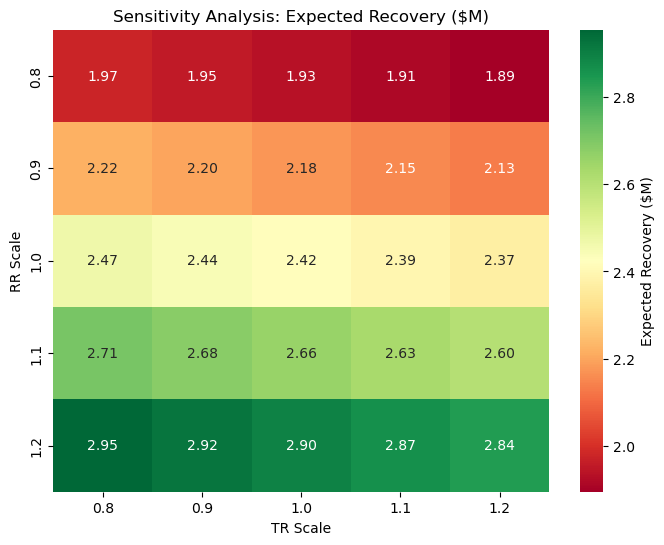


RR Sensitivity (% change in recovery per % change in RR):
RR_Scale
0.8   -20.005371
0.9   -10.022524
1.0     0.000000
1.1     9.971062
1.2    19.769464
Name: Expected_Recovery, dtype: float64

TR Sensitivity (% change in recovery per % change in TR):
TR_Scale
0.8    2.041291
0.9    0.998474
1.0    0.000000
1.1   -1.022914
1.2   -2.051363
Name: Expected_Recovery, dtype: float64


In [72]:

# Step 7: Summarize and visualize
print("\nSensitivity Analysis Results:")
print(results_df[['RR_Scale', 'TR_Scale', 'Expected_Recovery']].pivot(index='RR_Scale', columns='TR_Scale', values='Expected_Recovery') / 1e6, " (in $M)")

# Heatmap
pivot_table = results_df.pivot(index='RR_Scale', columns='TR_Scale', values='Expected_Recovery') / 1e6
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', cbar_kws={'label': 'Expected Recovery ($M)'})
plt.title('Sensitivity Analysis: Expected Recovery ($M)')
plt.xlabel('TR Scale')
plt.ylabel('RR Scale')
plt.show()

# Sensitivity metrics
base_recovery = results_df[(results_df['RR_Scale'] == 1.0) & (results_df['TR_Scale'] == 1.0)]['Expected_Recovery'].iloc[0]
rr_sensitivity = (results_df[results_df['TR_Scale'] == 1.0][['RR_Scale', 'Expected_Recovery']]
                  .set_index('RR_Scale')['Expected_Recovery'] / base_recovery - 1) * 100
tr_sensitivity = (results_df[results_df['RR_Scale'] == 1.0][['TR_Scale', 'Expected_Recovery']]
                  .set_index('TR_Scale')['Expected_Recovery'] / base_recovery - 1) * 100

print("\nRR Sensitivity (% change in recovery per % change in RR):")
print(rr_sensitivity)
print("\nTR Sensitivity (% change in recovery per % change in TR):")
print(tr_sensitivity)